<a href="https://colab.research.google.com/github/Jiachenn99/CW2_AIM/blob/master/CW2_AIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports, Initialization

In [1]:
#@title
from __future__ import print_function
version = '_v0p3p9_'

import time
import warnings
import csv

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import scipy
import pytz 
import random

from datetime import datetime, timezone,timedelta
from numpy import asarray
from numpy import savetxt
from numpy import genfromtxt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from tqdm import tqdm 

import torch
import numpy as np
from torch.utils import data
import copy

import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


from IPython.core.debugger import set_trace

from google.colab import drive,files,output
# ===============
# Initializations
# ===============

!pip install torch torchvision


## Declaring Framework Parameters

In [0]:
# ===============
# Parameters
# ===============

# --- General framework arguments

args = {}
kwargs = {}
args['num_train_batch'] = 1  # number of MNIST training batches
args['num_valid_batch'] = 10  # number of MNIST validation batches
args['train_batch_size'] = 100   # training batch size
args['valid_batch_size'] = 100   # validation batch size
args['test_batch_size'] = 10
# args['epochs'] = 100  # number of training epochs 
args['lr'] = 1 # 0.1  # 0.01 # learning rate # this is over-written by the solution
args['momentum'] = 0.5 # SGD momentum (default: 0.5); momentum is a moving average of our gradients (helps keep a useful direction)
args['clip_level'] = 0.5  # gradient clip threshold
args['seed']= 1 #random seed
args['log_interval_epoch'] = 1 # display training loss every log_int... epochs
args['cuda'] = True 
args['patience'] = 1000  # stop train. if the valid. err. hasn't improved by this num. of epochs
args['noise_in'] = -1   # 0.5  # 0.15  # amount of noise to add to the training data
args['noise_out'] = -1   #  probability of changing an output label to some random label
args['verbose_train'] = False   # print status of model training?
args['verbose_meta'] = True #  print status of architecture optimization?
args['min_inst_class'] = 5 # minimum number of instances per class in the training set
args['batch_max_tries'] = 10 # max. num. of attempts in extracting data batches
args['save_best_chrom'] = True # False  # save the best chromose in Google Drive?
args['dc_prob_drop'] = 0.5 # 0.5 # probability of dropping a circuit (DropCircuit)
args['prob_sel_branch'] = 0.5 # probability of architectural search selecting/using a branch (this is not DropCircuit) 

## Declaring Neural Network Architecture Parameters

In [0]:
# --- Neural architectural limits

args['num_epochs_search'] = 10 # 100  # number of epochs for training during architecture search 
args['num_epochs_test'] = 1000  # num. epochs for training during the final test
limits = {}
limits['min_layer_nodes'] =  10 # 5 # 50
limits['max_layer_nodes'] = 100
limits['max_pre_branch_layers'] = 5 # 3
limits['max_branches'] = 10
limits['max_branch_layers'] = 5  # 3
limits['max_post_branch_layers'] = 5 # 3
limits['lr1_min'] = 0.001
limits['lr1_,max'] = 2
limits['lr2_min'] = 0.001
limits['lr2_,max'] = 2
limits['moment_min'] = 0.001
limits['moment_max'] = 1

# np.random.seed(0)
# torch.manual_seed(0)

num_train_instances = args['num_train_batch'] * args['train_batch_size']
num_valid_instances = args['num_valid_batch'] * args['valid_batch_size']

data_rand_seed = 1 # (other pre-tested seeds: 2, 3)

## Load Dataset

In [0]:
# ============
# Load dataset
# ============

# Function to be added here to load dataset
def load_from_csv(path):
    '''
    Loads the csv file from path specified into a np array

    Args:
    path: Path where file is located
    e.g path='gdrive/My Drive/Chromosome Saves/chrom_acc72'

    Returns:
    None
    '''
    drive.mount('/content/gdrive/')
    some_file = np.genfromtxt(path, dtype='float', delimiter=',')

    return some_file


## Seed Creation

In [5]:
# Seed creation
torch.manual_seed(data_rand_seed)
np.random.seed(data_rand_seed)

a_data_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=a_data_transform),
    batch_size=args['train_batch_size'], shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=a_data_transform),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


## Classes


In [6]:
# Simple layer for doing elementwise scaling
# Adapated from https://stackoverflow.com/questions/51980654/pytorch-element-wise-filter-layer
class Elem_Scaling_1D(nn.Module):
  def __init__(self, num_nodes, bogus):  # clean-up "bogus"
    super(Elem_Scaling_1D, self).__init__()
    # Initialize
    init_weights = np.random.normal(loc=0, scale=0.5, size=np.shape(num_nodes))
    # Assign
    self.weights = torch.from_numpy(init_weights)
    #self.weights = nn.Parameter(torch.Tensor(1, num_nodes))  # trainable parameter

  def forward(self, x):
    # assuming x is of size num_inst-1-num_nodes
    return x * self.weights  # element-wise multiplication

# Class gradient-based neural diversity machine
class GBNDM(nn.Module):   
    def __init__(self, a_chromosome):   # assuming MNIST
        super(GBNDM, self).__init__()

        # --------- Pre-branch layers 
        self.chromosome = a_chromosome
        self.pre_branch_layers = nn.ModuleList()
        prev_num_out = 28*28
        chrom_ind = 5 # skip over 3 learning rate param., 1 moment. p. (interp./used in training)
        # and 1 exist-or-not (may use in future versions).
        # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
        for i in range(limits['max_pre_branch_layers']):
          
          # Extract and interpret parameters
          layer_params_raw = a_chromosome[chrom_ind:chrom_ind+6]
          layer_params_real = self.interp_layer_param(layer_params_raw)
        
          # Decide on whether to create a layer or not
          if i==0:  # the first layer of each segment is done by default
            do_layer = True
          else:
            do_layer = layer_params_real[0]

          if do_layer:
            # Create layer    
            a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
            # Append layer and update chromosome index
            self.pre_branch_layers.append(a_layer)
            
          chrom_ind += 6

        # --------- Branches
        num_out_pre_branch = prev_num_out

        self.branches = nn.ModuleList()

        # Scan over branches
        final_num_nodes = []  # keep track of the size of the final layer of each branch
        count_branches = 0
        for bi in range(limits['max_branches']):

          # Initialize branch
          branch_layers = nn.ModuleList()

          # Do branch? Always do the first one by default
          if (a_chromosome[chrom_ind] < args['prob_sel_branch']) or (bi == 0):
            do_branch = True
          else: 
            do_branch = False
            
          chrom_ind += 1

          # Scan over branch layers

          if do_branch:  # if doing branch

            this_fin_num_nodes = 0

            count_branches += 1
            
            for li in range(limits['max_branch_layers']):

              # Extract and interpret parameters
              layer_params_raw = a_chromosome[chrom_ind:chrom_ind+6]
              layer_params_real = self.interp_layer_param(layer_params_raw)

              # Decide on whether to create a layer or not
              if li==0:  # the first layer of each branch is done by default
                do_layer = True
                prev_num_out = num_out_pre_branch
              else:
                do_layer = layer_params_real[0]

              if do_layer:
                # print('... temp ... this_fin_num_nodes: {}.'.format(this_fin_num_nodes))
                # Create layer    
                a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
                # Num_nodes - keep storing the latest one; the last latest is the final layer num_nodes
                this_fin_num_nodes = prev_num_out
                # Append layer and update chromosome index
                branch_layers.append(a_layer)

              chrom_ind += 6

            # Append branch
            final_num_nodes.append(this_fin_num_nodes)
            #print('final_num_nodes: {}.'.format(final_num_nodes))
            self.branches.append(branch_layers)

          else: # if not doing branch you still need to increment chromosome index

            chrom_ind += 6*limits['max_branch_layers']

        self.num_branches = count_branches
        self.dc_prob_activ = 1 - args['dc_prob_drop'] # probability of using a circuit
        self.tot_nodes_branch_final = sum(final_num_nodes)
        
        # --------- Post-branch layers

        prev_num_out = self.tot_nodes_branch_final
        
        # --- Create post-branch layers

        chrom_ind += 1  # skip over the parameter pertaining to the existence or not of the post-branch segment

        self.post_branch_layers = nn.ModuleList()
        
        # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
        for li in range(limits['max_post_branch_layers']):
          
          # Extract and interpret parameters
          layer_params_raw = a_chromosome[chrom_ind:chrom_ind+6]
          layer_params_real = self.interp_layer_param(layer_params_raw)
        
          # Decide on whether to create a layer or not
          if li==0:  # the first layer of each segment is done by default
            do_layer = True
          else:
            do_layer = layer_params_real[0]

          if do_layer:
            # Create layer    
            a_layer, prev_num_out = self.create_layer(prev_num_out, layer_params_real)
            # Append layer and update chromosome index
            self.post_branch_layers.append(a_layer)
            
          chrom_ind += 6

        # Create a final layer
        self.final_layer = nn.Linear(prev_num_out, 10)

    def forward(self, x, dc_mask = None):
        
        x = x.view(-1, 28*28)

        # Apply pre-branch layers
        for pi, a_layer in enumerate(self.pre_branch_layers):
          #print('Pre-layer {}'.format(pi))
          # if isinstance(a_layer, Elem_Scaling_1D):
          #   set_trace()
          x = a_layer(x)

        # Apply branches
        branch_finals = []
        for bi, a_branch in enumerate(self.branches):
          #print('Branch {}'.format(bi))
          
          z = x

          for a_layer in a_branch:
            # if isinstance(a_layer, Elem_Scaling_1D):
            #   set_trace()
            z = a_layer(z)
          
          if self.training:
            z = (dc_mask[bi] * z) / self.dc_prob_activ  # if training apply DropCircuit
          
          branch_finals.append(z)

        # Concatenate multi-branch final layers
        x = torch.cat(branch_finals,dim=1)

        # if not(self.training): # if not training then testing/evaluating
        #   x = self.dc_prob_activ * x  # scaling due to DropCircuit
      

        # Apply post-branch layers
        for pi, a_layer in enumerate(self.post_branch_layers):
          #print('Post-layer: {}'.format(pi))
          # if isinstance(a_layer, Elem_Scaling_1D):
          #   set_trace()
          x = a_layer(x)

        # Apply final layer
        x = self.final_layer(x)
               
        return F.log_softmax(x, dim=1)


    # Method for interpreting layer parameters
    # Each layer is [exist-or-not, id-or-linear, activation function (AF), 2 AF parameters, number of nodes → total: 6 parameters]
    def interp_layer_param(self, layer_params_raw):
      # Exist or not
      if layer_params_raw[0] < 0.5:
        exist = False
      else:
        exist = True
      # Weight function
      tot_weight_func = 3
      if layer_params_raw[1] < 0.6: # or ... (1/tot_weight_func):  
        weight_func_sel = 'linear'
      elif layer_params_raw[1] < 0.8: # or ... (2/tot_weight_func):
        weight_func_sel = 'elem_scale'
      else:
        weight_func_sel = 'id'
      # activation function
      tot_node_func = 22
      if layer_params_raw[2] < (1/tot_node_func):
        activ_func = 'ReLU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (2/tot_node_func):
        activ_func = 'Hardshrink'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (3/tot_node_func):
        activ_func = 'Hardtanh'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = scale_to_range(layer_params_raw[4],0,2)
        if param_1 > param_2:  # param_1 is min_val; param_2 is max_val
          tmp_val = param_1
          param_1 = param_2
          param_2 = tmp_val
        elif param_1 == param_2:
          param_2 += 0.1
      elif layer_params_raw[2] < (4/tot_node_func):
        activ_func = 'LeakyReLU'
        param_1 = scale_to_range(layer_params_raw[3],0,1)
        param_2 = -1
      elif layer_params_raw[2] < (5/tot_node_func):
        activ_func = 'LogSigmoid'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (6/tot_node_func):
        activ_func = 'PReLU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (7/tot_node_func):
        activ_func = 'ELU'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (8/tot_node_func):
        activ_func = 'ReLU6'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (9/tot_node_func):
        activ_func = 'RReLU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (10/tot_node_func):
        activ_func = 'SELU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (11/tot_node_func):
        activ_func = 'CELU'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (12/tot_node_func):
        activ_func = 'GELU'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (13/tot_node_func):
        activ_func = 'Sigmoid'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (14/tot_node_func):
        activ_func = 'Softplus'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = scale_to_range(layer_params_raw[4],0,40)
      elif layer_params_raw[2] < (15/tot_node_func):
        activ_func = 'Softshrink'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = -1
      elif layer_params_raw[2] < (16/tot_node_func):
        activ_func = 'Softsign'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (17/tot_node_func):
        activ_func = 'Tanh'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (18/tot_node_func):
        activ_func = 'Tanhshrink'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (19/tot_node_func):
        activ_func = 'Threshold'
        param_1 = scale_to_range(layer_params_raw[3],0,2)
        param_2 = scale_to_range(layer_params_raw[4],0,2)
      elif layer_params_raw[2] < (20/tot_node_func):
        activ_func = 'Softmin'
        param_1 = -1
        param_2 = -1
      elif layer_params_raw[2] < (21/tot_node_func):
        activ_func = 'Softmax'
        param_1 = -1
        param_2 = -1
      else: 
        activ_func = 'None'
        param_1 = -1
        param_2 = -1

      # number of nodes
      num_nodes = scale_to_range(layer_params_raw[5], limits['min_layer_nodes'], limits['max_layer_nodes'])
      num_nodes = num_nodes.astype(int)

      return (exist, weight_func_sel, activ_func, param_1, param_2, num_nodes)

    # Method for creating a layer
    # layer_params_real format: (exist, weight_func_sel, activ_func, param_1, param_2, num_nodes)
    def create_layer(self, prev_num_out, layer_params_real):
      
      exist, weight_func_sel, activ_func, param_1, param_2, num_nodes = layer_params_real
      
      # wf_param1/wf_param2 --> not elegant 
      if weight_func_sel == 'linear':
        weight_func = nn.Linear
        num_nodes_in = prev_num_out
        num_nodes_out = num_nodes
        wf_param1 = num_nodes_in
        wf_param2 = num_nodes_out
      elif weight_func_sel == 'id':
        weight_func = nn.Identity
        num_nodes_in = prev_num_out
        num_nodes_out = prev_num_out
        wf_param1 = num_nodes_in
        wf_param2 = num_nodes_out
      else:  # 'elem_scale'
        weight_func = Elem_Scaling_1D
        num_nodes_in = prev_num_out
        num_nodes_out = prev_num_out
        wf_param1 = num_nodes_in
        wf_param2 = num_nodes_out
        
      if activ_func == 'ReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ReLU())
      elif activ_func == 'Hardshrink':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Hardshrink(param_1))
      elif activ_func == 'Hardtanh':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Hardtanh(param_1, param_2))
      elif activ_func == 'LeakyReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.LeakyReLU(param_1))
      elif activ_func == 'LogSigmoid':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.LogSigmoid())
      elif activ_func == 'PReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.PReLU())
      elif activ_func == 'ELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ELU(param_1))
      elif activ_func == 'ReLU6':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ReLU6())
      elif activ_func == 'RReLU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.RReLU())
      elif activ_func == 'SELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.SELU())
      elif activ_func == 'CELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.CELU(param_1))
      elif activ_func == 'GELU':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.ReLU())  # for some reason GELU is not present; revert later if relevant
      elif activ_func == 'Sigmoid':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Sigmoid())
      elif activ_func == 'Softplus':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softplus(param_1, param_2))
      elif activ_func == 'Softshrink':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softplus(param_1))
      elif activ_func == 'Softsign':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softsign())
      elif activ_func == 'Tanh':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Tanh())
      elif activ_func == 'Tanhshrink':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Tanhshrink())
      elif activ_func == 'Threshold':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Threshold(param_1, param_2))
      elif activ_func == 'Softmin':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softmin())
      elif activ_func == 'Softmax':
        a_layer = nn.Sequential(
            weight_func(wf_param1, wf_param2),
            nn.Softmax())
      else:
        a_layer = weight_func(wf_param1, wf_param2)

      return a_layer, num_nodes_out


## Training and Test Functions

In [0]:
# ==========================
# Train and test functions
# ==========================

# Compute the number of parameters in a chromose (depends on limits)
def comp_num_chrom_param(limits):
  # Num. of training parameters
  tot_train_param = 4 # lr1, lr2, lr2 prop, momentum
  # Num. of pre-branch parameters
  tot_pre_branch = 1+(6*limits['max_pre_branch_layers']) # exist-or-not, layer params.
  # Num. of branch parameters
  tot_branch = (1+(6*limits['max_branch_layers']))*limits['max_branches']
  # Num. of post-branch parameters
  tot_post_branch = 1+(6*limits['max_post_branch_layers'])

  return tot_train_param+tot_pre_branch+tot_branch+tot_post_branch

# Interpret learning rate and momentum parameters
def interp_lrm(params):
  lr1 = scale_to_range(params[0], limits['lr1_min'], limits['lr1_,max'])
  lr2 = scale_to_range(params[1], limits['lr2_min'], limits['lr2_,max'])
  if lr1 < lr2:
    temp = lr1
    lr1 = lr2
    lr2 = temp
  lr2_epoch = (np.round(params[2]*args['num_epochs_search'])).astype(int)
  a_decr = (lr1-lr2)/lr2_epoch
  a_momentum = scale_to_range(params[3], limits['moment_min'], limits['moment_max'])
  return lr1, lr2, lr2_epoch, a_momentum, a_decr

# Function to train a specific model
# Early stopping, or returning best validation model, is not implemented 
def do_training(a_model, train_params, num_epochs):

  lr1, lr2, lr2_epoch, a_momentum, lr_decr = train_params  
  args['lr'] = lr1
  args['momentum'] = a_momentum

  optimizer = optim.SGD(a_model.parameters(), lr=args['lr'], momentum=args['momentum'])
  best_valid_accur = 0
  best_model = type(a_model)(a_model.chromosome) # get a new instance
  valid_accurs = []
  train_accurs = []
  train_start_time = time.time()
  for epoch in range(1, num_epochs + 1):

    if args['verbose_train']:
      print('Epoch {} learning rate: {}.'.format(epoch, args['lr']))

    train_one_epoch(a_model, optimizer, epoch, train_batches)
    
    a_train_accur = comp_accuracy(a_model, train_batches, num_train_instances)
    if args['verbose_train']:
      print('Training accuracy: {}%.'.format(a_train_accur))
    train_accurs.append(a_train_accur)
    
    a_valid_accur = comp_accuracy(a_model, valid_batches, num_valid_instances)
    if args['verbose_train']:
      print('Validation accuracy: {}%.'.format(a_valid_accur))
    valid_accurs.append(a_valid_accur)
    if a_valid_accur > best_valid_accur:
      best_valid_accur = a_valid_accur
      # best_model.load_state_dict(a_model.state_dict()) # copy weights and stuff
      best_model = copy.deepcopy(a_model)

    # Decrement learning rate
    if epoch < lr2_epoch:
        args['lr'] -= lr_decr
        for param_group in optimizer.param_groups:
          param_group['lr'] = args['lr']

  train_elapsed_time = time.time() - train_start_time
#   print('The training process took {} seconds.'.format(train_elapsed_time))

  if args['cuda']:
      best_model.cuda()

  return a_model, best_model, valid_accurs, train_accurs
  
# Create a random mask for DropCircuit
def make_mask(num_circuits, prob_drop):
  rand_vals = np.random.rand(num_circuits)
  decisions = rand_vals >= prob_drop
  a_mask = np.ones(num_circuits)*decisions
  # Must have at least one circuit active
  if np.sum(a_mask) == 0:
    rand_index = np.random.randint(num_circuits)
    a_mask[rand_index] = 1.0

  return torch.from_numpy(a_mask)

def train_one_epoch(a_model, optimizer, epoch, batches):

  a_model.train()
  for batch_idx, (data, target) in enumerate(batches):
      if args['cuda']:
          data, target = data.cuda(), target.cuda()
      # Variables in Pytorch are differentiable. 
      
      data, target = Variable(data), Variable(target)
      #This will zero out the gradients for this batch. 
      optimizer.zero_grad()
      
      # Create DropCircuit mask
      dc_mask = make_mask(a_model.num_branches, args['dc_prob_drop'])
      
      output = a_model(data, dc_mask)

      # Calculate the negative log likelihood loss.
      loss = F.nll_loss(output, target)
      #dloss/dx for every Variable 
      loss.backward()
      # Gradient clipping
      torch.nn.utils.clip_grad_norm_(a_model.parameters(), args['clip_level'])
      #to do a one-step update on our parameter.
      optimizer.step()
      #Print out the loss periodically. 

  if args['verbose_train']:
    if epoch % args['log_interval_epoch'] == 0:
      print('Epoch: {}. Latest loss: {}.'.format(epoch, loss.data))

# Compute accuracy
# The argument (data_source) of this function can be a data_loader or a list of batches (previously extracted) 
def comp_accuracy(a_model, data_source, src_num_instances):
    a_model.eval()
    a_loss = 0
    correct = 0
    preds = torch.zeros(0)
    first = True
    for a_data_in, a_data_out in data_source:
        if args['cuda']:
            a_data_in, a_data_out = a_data_in.cuda(), a_data_out.cuda()
        a_data_in, a_data_out = Variable(a_data_in), Variable(a_data_out)
        output = a_model(a_data_in)

        a_loss += F.nll_loss(output, a_data_out, reduction='sum').data # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        if first:
          preds = pred
          first = False
        else:
          preds = torch.cat((preds, pred),0)

        correct += pred.eq(a_data_out.data.view_as(pred)).long().cpu().sum()

    # Compute and return accuracy
    if type(data_source) == list:  # case: list of batches
      result = 100. * (correct.numpy()/ src_num_instances)
    else: # case: data_loader
      result = 100. * (correct.numpy()/ len(data_source.dataset))
    return result

## Data Prep, Visualization, Gen Chrom





In [8]:
# Check whether we have enough instances per class
# We want an imbalanced dataset but we don't want any specific label having
# an "insufficient" number of instances.
def check_enough_inst(batches, min_inst_per_class):
  
  # Concatenate training batch output labels
  labels = batches[0][1].numpy()
  for batch_i in range(1,args['num_train_batch']):
    new_labels = batches[batch_i][1].numpy()
    labels = np.concatenate((labels, new_labels))

  labels = labels.tolist()

  # Scan though labels
  for a_label in range(10):  # assuming MNIST, of course
    a_count = labels.count(a_label)
    # If label count is < min_inst_per_class return False
    if a_count < min_inst_per_class:
      return False

  # Return True
  return True


# Prepare data. Extract training and validation batches
# This is where we make the problem "small and imbalanced"
def extract_batches(a_loader, min_inst_per_class, max_tries):

  # Keep trying until you have a required minimum number of instances 
  # per class in the training set (not elegant but ok for the range of 
  # "min_inst_per_class" we need)

  for ti in range(max_tries):

    print('Data extraction trial {}.'.format(ti))

    # Initializations
    train_batches = []
    valid_batches = []
    tot_batch_extract = args['num_train_batch'] + args['num_valid_batch']

    # Extract
    for batch_idx, (data, target) in enumerate(a_loader):

      if batch_idx < args['num_train_batch']:
        train_batches.append((data,target))
      else:
        valid_batches.append((data,target))
        if batch_idx == tot_batch_extract - 1:
          break

    # Check minimum number of instances
    enough_instaces = check_enough_inst(train_batches, min_inst_per_class)
    if enough_instaces:
      return train_batches, valid_batches

  print('It was not possible to create a dataset.')
  print('Consider increasing the overall number of instances, or')
  print('decreasing the minimum instances per class allowed.')
  return [], []

# ===========================
# Display histogram of labels
# ===========================

def disp_hist_labaels(batches):
  # Concatenate training batch output labels
  labels = batches[0][1].numpy()
  for batch_i in range(1,args['num_train_batch']):
    new_labels = batches[batch_i][1].numpy()
    labels = np.concatenate((labels, new_labels))

  num_bins = 10
  n, bins, patches = plt.hist(labels, num_bins, facecolor='blue', alpha=0.5)
  plt.show()

# This is not currently used

# Display MNIST instances
# Adapted from # https://github.com/CSCfi/machine-learning-scripts/blob/master/notebooks/pytorch-mnist-mlp.ipynb
def disp_MNIST_inst(num_disp, X_train, y_train):
  pltsize=1
  plt.figure(figsize=(num_disp*pltsize, pltsize))
  for i in range(num_disp):
    plt.subplot(1,num_disp,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:].numpy().reshape(28,28), cmap="gray_r")
    plt.title('Class: '+str(y_train[i].item()))

# Simple function to scale parameters
# num is assume to be \in [0,1]
def scale_to_range(num,min_val,max_val):
  range = max_val - min_val
  return (num*range)+min_val

# Generate a random chromosome where each param. is \in [0,1)
def gen_rand_chromosome(num_param):
  chrom = np.random.rand(num_param)
  return chrom

## Display Data Distribution


Data extraction trial 0.
Data extraction trial 1.


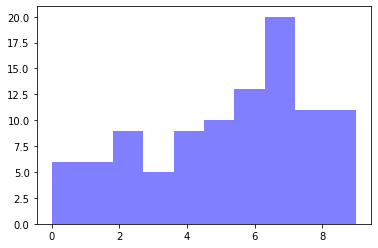

In [9]:
train_batches, valid_batches = extract_batches(train_loader, args['min_inst_class'], args['batch_max_tries'])
if args['verbose_train']:
  print('Extracted {} train_batches, and {} valid_batches.'.format(len(train_batches), len(valid_batches)))


disp_hist_labaels(train_batches)

# ==========================
# Display dataset
# ==========================


if args['verbose_train']:
  X_train = train_batches[0][0]
  y_train = train_batches[0][1]

  disp_MNIST_inst(10, X_train, y_train)

  sum_train_0 = X_train[0,:,:].sum()
  min_train_0 = X_train[0,:,:].min()
  max_train_0 = X_train[0,:,:].max()

  print('X_train[0,:,:] --> sum ({}); min ({}); max ({}).'.format(sum_train_0, min_train_0, max_train_0))

# ==========================
# Design model
# ==========================

# "Unseed" the rest
np.random.seed()
a_rand_seed = np.random.randint(0,999999)
torch.manual_seed(a_rand_seed)

# **Work To be Done Starts Here**


---

## Prepare Model, Neighbour Creation Functions

In [0]:
# Prepare model
def prepare_model(a_rand_chrom):
    # Initialize chromosome and model
    model = GBNDM(a_rand_chrom)
  
    if args['cuda']:
        model.cuda()

    # Interpret learning rates and momentum
    lr1, lr2, lr2_epoch, a_momentum, lr_decr = interp_lrm(a_rand_chrom[0:4])
    train_params = (lr1, lr2, lr2_epoch, a_momentum, lr_decr)
    args['momentum'] = a_momentum
    if args['verbose_train']:
        print('lr1: {}'.format(lr1))
        print('lr2: {}'.format(lr2))
        print('lr2_epoch: {}'.format(lr2_epoch))
        print('a_momentum: {}'.format(a_momentum))
        print('lr_decr: {}'.format(lr_decr))

    return model, train_params

# Function for creating one neighbour
def create_a_neighbour(a_chromosome, neighbour_range, num_chrom_params):
    
    mutat_vec = (np.random.rand(num_chrom_params)*neighbour_range)+(neighbour_range/2)

    # Add mutation vector
    new_chromosome = a_chromosome + mutat_vec

    # Clip
    np.clip(new_chromosome, 0, 0.99999999999, out=new_chromosome)

    return new_chromosome

      
# Function for creating a list of neighbours
def create_neighbours(a_chromosome, meta, num_chrom_params):
    neighbours = []
    # Scan through number of neighbours
    for ni in range(meta['num_neighbours']):
        # Create neighbour
        a_neighb = create_a_neighbour(a_chromosome, meta['neighbour_range'], num_chrom_params)
        
        # Append neighbour
        neighbours.append(a_neighb)

    return neighbours


## Differential Search Function (To be looked at and worked on)


In [0]:
# Simple differential search
def do_diff_chrom_v1(mat_chrom_accur, num_new_sol):
  
  # Initialize new chromosomes
    num_chrom = mat_chrom_accur.shape[0]
    if num_new_sol >= num_chrom:
        num_new_sol = num_chrom-1
    new_chromosomes = []

    # Sort the array of chromosomes based on the first column (contains accur.)
    mat_chrom_accur = mat_chrom_accur[(-mat_chrom_accur[:,0]).argsort()]
    # print(mat_chrom_accur[:,0:4])

    # Extract first/best chromosome
    best_chrom = mat_chrom_accur[0,1:]

    # Scan through new solutions
    for si in range(num_new_sol):  

        # Extract next best chrom
        next_best_chrom = mat_chrom_accur[1+si,1:]

        # Compute differential
        a_diff = best_chrom - next_best_chrom

        # Add differential whilst applying a learning rate
        a_new_chrom = best_chrom + (meta['diff_lr']*a_diff)
        np.clip(a_new_chrom, 0, 0.99999999999, out=a_new_chrom)

        # Store new solution 
        new_chromosomes.append(a_new_chrom)

    return new_chromosomes


## Model Test Function

In [0]:
# ==========================
# Test final model / Visualize predictions
# ==========================

def final_test(a_model):
    a_model.eval()
    test_loss = 0
    correct = 0
    test_preds = torch.zeros(0)
    first = True
    for test_data_in, test_data_out in test_loader: 

        if args['cuda']:
            test_data_in, test_data_out = test_data_in.cuda(), test_data_out.cuda()
                
        test_data_in, test_data_out = Variable(test_data_in), Variable(test_data_out)
        output = a_model(test_data_in)
        test_loss += F.nll_loss(output, test_data_out, reduction='sum').data # sum up batch loss

        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        if first:
          test_preds = pred
          first = False
        else:
          test_preds = torch.cat((test_preds, pred),0)

        correct += pred.eq(test_data_out.data.view_as(pred)).long().cpu().sum()

    # Print test accuracy
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy (at final epoch): {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

    return accuracy


## Graph Plotting, Metric Calculation Functions


In [0]:
def plot_bar(x_axis, y_axis):
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    x_axis = [f'Trial {i+1}' for i in x_axis]
    ax.bar(x_axis, height = y_axis, width = 0.5)
    ax.set_ylabel('Accuracy')
    # ax.set_ylim(bottom = (0,100))
    ax.set_ybound(lower = 0, upper = 100)
    # ax.set_yticks(y_axis) # displays the exact ticks
    for x,y in enumerate(y_axis):
        ax.text(x-0.20, y+5, str(y))
    plt.show()

def plot_bar_2(x_axis, y_axis):

    # Specifies the positions on the x_axis for ticks to be labeled
    y_pos = np.arange(len(x_axis))

    # Formatting for the x_axis labels
    objects = ['Trial {}'.format(i+1) for i in x_axis]

    # Calculate metrics for error bar handling
    std_dev, mean, variance = calculate_metrics(y_axis)

    # Plot bar graph
    plt.bar(y_pos, y_axis, align='center', alpha=0.5, color ='b', yerr=std_dev, tick_label = y_axis)
    plt.xticks(y_pos, objects, rotation = 90)
    plt.ylabel('Accuracy')
    plt.title('Accuracies over 10 trials')
    plt.ylim(top=100)
    file_name = 'Mean Accuracy {}.png'.format(mean)
    for x,y in enumerate(y_axis):
        plt.text(x-0.20, y+3, str(y))
    plt.savefig(file_name, bbox_inches='tight')

    # files.download(file_name)

    
def plot_line_graph(x_axis, y_axis):
    # Specifies the positions on the x_axis for ticks to be labeled
    y_pos = np.arange(len(x_axis))

    # Formatting for the x_axis labels
    objects = ['Iteration {}'.format(i+1) for i in x_axis]

    obj = dict(zip(y_pos, y_axis))

    # plt.plot('Iterations', 'Accuracy', data=obj)
    plt.plot(y_pos, y_axis)
    plt.xticks(y_pos, objects)
    plt.ylabel('Accuracy')
    plt.title('Accuracies of every model')

def calculate_metrics(y_axis):

    # Error bar handling
    std_dev = np.std(y_axis)
    mean = np.mean(y_axis)
    variance = np.var(y_axis)

    print('Mean accuracy of models are {}'.format(mean))
    print('Mean variance of results is {}'.format(variance))
    print('Standard deviation of results is {}'.format(std_dev))

    return std_dev, mean, variance

## File read/write



In [0]:
def load_from_csv(path):
    '''
    Loads the chromosome from path specified into a np array

    Args:
    path: Path where chromosome is located
    e.g path='gdrive/My Drive/Chromosome Saves/chrom_acc72'

    Returns:
    None
    '''
    drive.mount('/content/gdrive/')
    some_file = np.genfromtxt(path, dtype='float', delimiter=',')

    return some_file

def update_file_with_metrics(path,iterations, evaluations, time_taken, y_axis, parameter_dict, learning_rate_list):
    drive.mount('/content/gdrive/')

    std_dev, mean, variance = calculate_metrics(y_axis)
    temp_counter = 0
    datetime_now = datetime.now() + timedelta(hours=8)

    with open(path+'results.txt', 'a+') as f:
        f.write('================================\n')
        f.write('New Results\n')
        f.write('================================\n')
        f.write(datetime_now.strftime('%Y-%b-%d, %H%M hours\n'))
        f.write(f'Trials used: {iterations}\n')
        f.write(f'Mean accuracy: {mean}\n')
        f.write(f'Number of evaluations taken: {evaluations}\n')
        f.write(f'Time taken: {time_taken}\n')
        f.write(f'Standard deviation: {std_dev}\n')
        f.write(f'Variance: {variance}\n')

        for key,value in parameter_dict.items():
            f.write(f'{key}: {value}\n')

        f.write('List of Accuracies: \n')
        f.write(f'{str(y_axis)}\n')

        f.write(f'List of diff search learning rates: {learning_rate_list}\n')
        for values in learning_rate_list:
            temp_counter += values
        temp_counter /= iterations
        f.write(f'Average learning rate for differential search: {temp_counter}\n')
        f.write('\n')       
    

## Chromosome Evaluation function

In [0]:
# Evaluate a list of chromosomes
def eval_chromosomes(list_chromosomes,num_chrom_params):
    '''
    Evaluates a list of x chromosomes and chooses the best one, where x is number of neighbours specified
    
    Args:
    list_chromosomes: list, containing list of values
    num_chrom_params: int, number of parameters a chromosome has

    Returns:
    best_res: tuple, containg the best results, could be from different chromosomes
    '''

    # best_model_accur, best_chromosome, best_model, best_train_params = best_res

    best_model_accur = 0
    best_chromosome = None
    best_model = None
    best_train_params = None

    num_chrom = len(list_chromosomes)

    temp_tuple = ()
    temp_list = []

    # List of zeroes in the shape [num_chrom, 1+num_chrom_params]
    mat_chrom_acur = np.zeros((num_chrom, 1+num_chrom_params))
    neighb_valid_accurs = []

    for ci, a_chrom in enumerate(list_chromosomes):
        # if args['verbose_meta']:
        #     print('Chromosome {} ...'.format(ci))

        # --- Actual training
        model, train_params = prepare_model(a_chrom)
        model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
        best_valid_accur = max(valid_accurs)

        # Store chromosome and accuracy
        # mat_chrom_acur will be a (2,376) np array
        mat_chrom_acur[ci,0] = best_valid_accur
        mat_chrom_acur[ci,1:] = a_chrom
        print('Best validation accuracy: {}%.'.format(best_valid_accur))
        neighb_valid_accurs.append(best_valid_accur)

        if best_valid_accur > best_model_accur:
            best_model_accur = best_valid_accur
            best_chromosome = a_chrom
            best_model = model
            best_train_params = train_params
            
        # if args['verbose_meta']:
        #     print('*** Improving validation accuracy: {}.'.format(best_model_accur))


    
    best_res = (best_model_accur, best_chromosome, best_model, best_train_params)
    return best_res, mat_chrom_acur

# Add early stopping if algorithm does not progress well here
def do_eval_chrom(a_model, train_params, num_epochs):
    '''
    Chromosome evaluation (more efficient than do_training)
    Function to train a specific model
    Early stopping, or returning best validation model, is not implemented 
    '''

    # Extract basic information
    lr1, lr2, lr2_epoch, a_momentum, lr_decr = train_params  
    args['lr'] = lr1
    args['momentum'] = a_momentum

    optimizer = optim.SGD(a_model.parameters(), lr=args['lr'], momentum=args['momentum'])
    valid_accurs = []
    train_accurs = []
    train_start_time = time.time()
    for epoch in range(1, num_epochs + 1):

        if args['verbose_train']:
            print('Epoch {} learning rate: {}.'.format(epoch, args['lr']))

        train_one_epoch(a_model, optimizer, epoch, train_batches)

        # Training accuracy test
        a_train_accur = comp_accuracy(a_model, train_batches, num_train_instances)
        if args['verbose_train']:
            print('Training accuracy: {}%.'.format(a_train_accur))
        train_accurs.append(a_train_accur)

        # Validation accuracy test
        a_valid_accur = comp_accuracy(a_model, valid_batches, num_valid_instances)
        if args['verbose_train']:
            print('Validation accuracy: {}%.'.format(a_valid_accur))
        valid_accurs.append(a_valid_accur)

        # Decrement learning rate
        if epoch < lr2_epoch:
            args['lr'] -= lr_decr
            for param_group in optimizer.param_groups:
                param_group['lr'] = args['lr']

    train_elapsed_time = time.time() - train_start_time
    # print('The training process took {} seconds.'.format(train_elapsed_time))

    return a_model, valid_accurs, train_accurs

## Architectural Search (Work on this part)

In [0]:
# ================================
# Architectureal search
# ================================

# Artificial Intelligence Methods students should focus on the code below.
# You should keep the neural network code unchaged. This is crucial for 
# comparison purposes. In other words, focus only on modifying the architecture
# search code below.

# --- Architectural search parameters
meta = {}
meta['max_rs_iter'] = 20 # 10  # initial random search
meta['max_shc_iter'] = 10 # 40 # 20 # 40  # stochastic hill climbing iterations
meta['num_neighbours'] = 6 # 16 
meta['neighbour_range'] = 0.4  # 0.2  # mutation rate for stochastic hill-climbing
meta['num_differential_sol'] = 6 # 8 # number of differential evolution solutions
meta['diff_lr'] = 0.1 # 0.1 # learning rate for differential search

# Start with a small random search
print('Initital random search ...')

# Performing the search based off the number of iterations defined in settings
x_axis_plot = []
y_axis_plot = []
evaluation_counter = 0

# Starting time of 10 iterations
total_time_taken = 0
iteration_start_time = time.time()

for trials in range(1): # 10 iterations
    print('======================================')
    print('THIS IS TRIAL {}'.format(trials))
    print('======================================')

    # Can reinitialize with new chromosome
    meta_rs_valids = [] # List that will contain best validation accuracies
    best_model = None

    best_chromosome = None
    best_model_accur = 0
    population_list = []
    # Random search
    for rsi in range(meta['max_rs_iter']):
        if args['verbose_meta']:
            print('Search iteration {}.'.format(rsi+1))

        num_chrom_param = comp_num_chrom_param(limits)

        # Generate random chromosomes
        a_rand_chrom = gen_rand_chromosome(num_chrom_param)

        # --- Actual training
        # Base model and training parameters
        model, train_params = prepare_model(a_rand_chrom)

        # New model after evaluation
        model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
        evaluation_counter += 1
        best_valid_accur = max(valid_accurs)
        print('Best validation accuracy: {}%.'.format(best_valid_accur))

        # Store best model
        if best_valid_accur > best_model_accur:
            best_model_accur = best_valid_accur
            best_model = model
            best_train_params = train_params
            best_chromosome = a_rand_chrom

        population_list.append((best_valid_accur,model, train_params, a_rand_chrom))
        
        # Best validation accuracy is put into a list
        meta_rs_valids.append(best_valid_accur)

    print('*****************************************************')
    print('Best accuracy after initial random search: {}'.format(best_model_accur))
    print('*****************************************************')

    if args['verbose_meta']:
        print('Best validation errors: {}\n'.format(meta_rs_valids))

    # # --- Stochastic hill climbing
    num_chrom_params = best_chromosome.shape[0] # Number of parameters in the chromosome (1st argument of tuple) - 376 params

    # Architectural search iterations
    best_res = (best_model_accur, best_chromosome, best_model, best_train_params) # Tuple containing best parameters
    meta_start_time = time.time()

    # Does stochastic hill climbing for ['max_shc_iter'] times
    for shci in range(meta['max_shc_iter']):
        best_model_accur, best_chromosome, best_model, best_train_params = best_res

        if args['verbose_meta']:
            print('======================================')
            print('Stochastic hill-climbing iteration {}.'.format(shci))
            print('======================================')
            print('Best accuracy so far: {}'.format(best_model_accur))
            print('======================================')

        # --- Create a set of stochastic neighbours from the current best model
        # Random neighbours
        chrom_neighbors = create_neighbours(best_chromosome, meta, num_chrom_params)

        # Test validation accuracies of neighbours
        new_res, mat_chrom_acur = eval_chromosomes(chrom_neighbors,num_chrom_params)

        if new_res[0] > best_res[0]:
            best_res = new_res

        print('***********************************************')
        print('Best accuracy after random mutation: {}'.format(new_res[0]))
        print('***********************************************')
        
        # --- Simple differential search
        print('***** Differential Search *********************')
        diff_chromosomes = do_diff_chrom_v1(mat_chrom_acur, meta['num_differential_sol'])
        new_res, mat_chrom_acur = eval_chromosomes(diff_chromosomes,num_chrom_params)

        if new_res[0] > best_res[0]:
            best_res = new_res

        print('***********************************************')
        print('Best accuracy after differential search: {}'.format(new_res[0]))
        print('***********************************************')

        meta_elapsed_time = time.time() - meta_start_time

        if args['verbose_meta']:
            print('=====================================================')
            print('Architectural optimization total time: {}.'.format(meta_elapsed_time))
            print('=====================================================')
        
        # Final visualization
        print('======================================')
        print('Best accuracy so far: {}'.format(best_res[0]))
        print('======================================')

        print('Computing the final test ...')
        best_model_accur, best_chromosome, best_model, best_train_params = best_res
        final_model, best_valid_model, valid_accurs, train_accurs = do_training(best_model, best_train_params, args['num_epochs_test'])

        print('=====================================')
        print('Training accuracies')
        print('=====================================')
        print(train_accurs)

        # print('=====================================')
        # print('Best training parameters')
        # print('=====================================')
        # print(best_train_params)

        print('=====================================')
        # print('Best model')
        # print('=====================================')
        # print(best_valid_model)

        print('=====================================')
        print('Test accuracies')
        print('=====================================')

        print('Model with best validation accuracy: ')
        accur_valid = final_test(best_valid_model)

        print('Model at the end of training: ')
        accur_final = final_test(final_model)

        max_accur = int(max(accur_valid, accur_final))
            
    # Creating a list of values to plot graph / statistical analysis
    x_axis_plot.append(trials)
    y_axis_plot.append(max_accur)

    total_time_taken = time.time() - iteration_start_time



## Save chromosome

In [0]:
# --- Saving the best chromosome as a csv file
# if args['save_best_chrom']:
#     print('Saving the best chromosome in the root directory (My Drive) ...')
#     drive.mount('/content/gdrive/')

#     def get_date_time_str():
#         now = datetime.now() # current date and time
#         return now.strftime("%d%m%Y_%H%M") 

#     # Create filename
#     path = '/content/gdrive/My Drive/Chromosome Saves/'
#     filename = 'chrom_acc'+ str(max_accur)
# #   filename = 'chrom_' + get_date_time_str() + version + str(max_accur)
#     savetxt(path+filename, best_chromosome, delimiter=',')

# Testing Site

## Generate Offspring & Tournament Selection

In [0]:
def generate_offspring(population_list):

    # ========================================================
    #                      Reproduction                       
    # ========================================================
    #     - Performs reproduction to generate offspring
    # ========================================================

    """
    Args:
        population_list: List of exisitng population
        offspring_num: An integer value representing num of offspring
                        to be produced, defaulted to 10

    Returns:
        offspring_list: List of offspring generated by the algorithm
    """

    # Select the first 10 chromosomes (tuples actually)
    # Perhaps can use fitness wheel to do it 
    population_list.sort(key=lambda tuples:tuples[0], reverse=True)

    # Select top half chrom based off accuracy
    pop_list_len = len(population_list)
    half_len = math.ceil(pop_list_len/2)

    mating_pool= population_list[0:half_len]
    offspring_num = math.floor(pop_list_len/2)

    # Length of chromosome
    chrom_len = len(mating_pool[0][1])
    offspring_list = []
    
    # Crossover
    for i in range(offspring_num):
        crossover_point = random.randint(1,chrom_len-1)
        rand_chrom1 = random.randint(0,half_len-1)
        rand_chrom2 = random.randint(0,half_len-1)
        offspring = []

        if rand_chrom1 != rand_chrom2:
            parent1 = mating_pool[rand_chrom1][1][0:crossover_point]
            parent2 = mating_pool[rand_chrom2][1][crossover_point:]
            # print(f'Chromosome {rand_chrom1} and {rand_chrom2} were selected to mate')
            # print(f'Crossover point is {crossover_point}\n')

        else:
            print(f'Value of chrom1 and chrom2 are {rand_chrom1} & {rand_chrom2}')
            while rand_chrom1 == rand_chrom2:
                rand_chrom1 = random.randint(0,half_len-1)
                rand_chrom2 = random.randint(0,half_len-1)
                # print('Retinitializing rand_chrom\n')

            parent1 = mating_pool[rand_chrom1][1][0:crossover_point]
            parent2 = mating_pool[rand_chrom2][1][crossover_point:]
            # print(f'Chromosome {rand_chrom1} and {rand_chrom2} were selected to mate')
            # print(f'Crossover point is {crossover_point}\n')

        offspring[0:crossover_point] = parent1
        offspring[crossover_point:] = parent2
        offspring = np.asarray(offspring)
        offspring_list.append(offspring)

    # check for length of chromosome
    for i in range(len(offspring_list)):
        if len(offspring_list[i]) != 376:
            print(f'Error, num of chromosomes only at {len(offspring_list[i])}')
            break

    # Mutation
    for offspring in offspring_list:
        mutation_prob = np.random.rand()

        if mutation_prob < 0.025:
            mutated_allele = np.random.randint(0,376,2)
            # print(f'Mutated allele is {mutated_allele}\n')
            start_mutate = min(mutated_allele)
            end_mutate = max(mutated_allele)

            mutate_section = offspring[start_mutate:end_mutate]
            # print(f'Section before mutate is {offspring[start_mutate:end_mutate]}')
            np.random.shuffle(mutate_section)
            offspring[start_mutate:end_mutate] = mutate_section
            # print(f'Section after mutate is {offspring[start_mutate:end_mutate]}')

        # print(f'mutation prob: {mutation_prob}')

    return offspring_list

def initial_selection(population_list):

    # Evaluates the chromosomes straight away with the final test method
    # for individual in population_list:
    #     best_valid_accur, chromosome, model, train_params = individual
    #     final_model, best_valid_model, valid_accurs, train_accurs = do_training(model, train_params, args['num_epochs_test'])

    #     accur_valid = final_test(best_valid_model)
    #     accur_final = final_test(final_model)

    #     if accur_valid > accur_final:
    #         individual = ((best_valid_accur, a_rand_chrom, best_valid_model, train_params),accur_valid)
    #     else:
    #         individual = ((best_valid_accur, a_rand_chrom, final_model, train_params),accur_final)

    # Select individuals to be the population
    population_list.sort(key = lambda x:x[0], reverse = True)

    initial_population = [individual for individual in population_list[0:meta['population_size']]]

    return initial_population

## Evaluate Offspring and Replace Population

In [0]:
def eval_offspring(offspring_list):

    num_chrom_param = comp_num_chrom_param(limits)
    new_population = []
    offspring_complete = ()

    for chromosome in offspring_list:
        model,train_params = prepare_model(chromosome)
        model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
        best_valid_accur = max(valid_accurs)
        offspring_complete = (best_valid_accur, chromosome, model, train_params)
        # offspring_complete = (best_valid_accur, model, train_params, chromosome)
        print(f'Max valid accuracy is {best_valid_accur}')
        new_population.append(offspring_complete)

    return new_population

def replace_population(offspring_list, population_list):
    # replace_pop_list_len = math.ceil(len(population_list)/2)
    # Replace half the population
    replace_pop_list_len = math.ceil(meta['population_size']/2)

    offspring_list.sort(key= lambda x:x[0], reverse = True)

    population_list[replace_pop_list_len:] = offspring_list[0:replace_pop_list_len]

    population_list.sort(key=lambda x:x[0], reverse=True)
    return population_list


## GA + Hill Climbing 

In [0]:
# --- Architectural search parameters
meta = {}
meta['max_rs_iter'] = 20 # 10  # initial random search
meta['max_shc_iter'] = 10 # 40 # 20 # 40  # stochastic hill climbing iterations
meta['num_neighbours'] = 8 # 16 
meta['neighbour_range'] = 0.5  # 0.2  # mutation rate for stochastic hill-climbing
meta['num_differential_sol'] = 6 # 8 # number of differential evolution solutions
meta['diff_lr'] = 0.1 # 0.1 # learning rate for differential search
meta['population_size'] = 10

# Start with a small random search
print('Initital random search ...')

# Performing the search based off the number of iterations defined in settings

evaluation_counter = 0

# Starting time of 10 iterations
total_time_taken = 0
iteration_start_time = time.time()

for generations in range(5): # 10 iterations
    print('==========================================')
    print(f'THIS IS GENERATION {generations}')
    print('==========================================')
   
    model = None
    chromosome = None
    model_accur = 0
    x_axis_plot = []
    y_axis_plot = []
    some_count = 0

    if generations == 0:
        population_list = []
        # Random search to generate chromosomes for first iteration
        for rsi in range(meta['population_size']):
            if args['verbose_meta']:
                print('Search iteration {}.'.format(rsi+1))

            num_chrom_param = comp_num_chrom_param(limits)

            # Generate random chromosomes
            a_rand_chrom = gen_rand_chromosome(num_chrom_param)

            # --- Actual training
            # Base model and training parameters
            model, train_params = prepare_model(a_rand_chrom)

            # New model after evaluation
            # Evaluation of chromosome
            model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])
            evaluation_counter += 1

            best_valid_accur = max(valid_accurs)
            print('Best validation accuracy: {}%.\n'.format(best_valid_accur))

            # Append all accuracy, model, train params and chromosome to a list in a tuple
            population_list.append((best_valid_accur, model, train_params, a_rand_chrom))
            # population_list.append((best_valid_accur, a_rand_chrom, model, train_params))
    else:
        offspring_list = generate_offspring(population_list)
        completed_offspring = eval_offspring(offspring_list)
        completed_offspring.sort(key=lambda x:x[0], reverse=True)
        
        # Replace the population
        population_list = replace_population(completed_offspring, population_list)

    print(f'Best model acc: {population_list[0][0]}')

    ## --- Stochastic hill climbing
    for chrom_count, chrom in enumerate(population_list):
        print(f'On chromosome {chrom_count}\n')
        num_chrom_params = chrom[3].shape[0] # Number of parameters in the chromosome (1st argument of tuple) - 376 params

        # Architectural search iterations
        model_accur = chrom[0]
        model = chrom[1]
        train_params = chrom[2]
        chromosome = chrom[3]

        chrom_res = (model_accur, chromosome, model, train_params)

        # best_res = (best_model_accur, best_chromosome, best_model, best_train_params) 
        meta_start_time = time.time()
        meta['diff_lr'] = 0.1
        some_final_list = []
        some_final_chrom = ()

        # Does stochastic hill climbing for ['max_shc_iter'] times
        for shci in range(meta['max_shc_iter']):
            some_count += 1
            # best_model_accur, best_chromosome, best_model, best_train_params = best_res
            model_accur, chromosome, model, train_params = chrom_res

            if args['verbose_meta']:
                print('======================================')
                print('Stochastic hill-climbing iteration {}.'.format(shci))
                print('======================================')
                print('Best accuracy so far: {}'.format(model_accur))
                print('======================================')

            # --- Create a set of stochastic neighbours from the current best model
            # Random neighbours
            chrom_neighbors = create_neighbours(chromosome, meta, num_chrom_params)

            # Test validation accuracies of neighbours
            new_res, mat_chrom_acur = eval_chromosomes(chrom_neighbors,num_chrom_params)

            if new_res[0] > chrom_res[0]:
                chrom_res = new_res
                meta['diff_lr'] = 0.1

            print('***********************************************')
            print('Best accuracy after random mutation: {}'.format(new_res[0]))
            print('***********************************************')
            
            # --- Simple differential search
            print('******** Differential Search *********************')
            diff_chromosomes = do_diff_chrom_v1(mat_chrom_acur, meta['num_differential_sol'])
            new_res, mat_chrom_acur = eval_chromosomes(diff_chromosomes,num_chrom_params)

            if new_res[0] > chrom_res[0]:
                chrom_res = new_res
                meta['diff_lr'] = 0.1

            print('***********************************************')
            print('Best accuracy after differential search: {}'.format(chrom_res[0]))
            print('***********************************************')

            meta_elapsed_time = time.time() - meta_start_time

            if args['verbose_meta']:
                print('=====================================================')
                print('Architectural optimization total time: {}.'.format(meta_elapsed_time))
                print('=====================================================')
            
            # Final visualization
            print('======================================')
            print('Best accuracy so far: {}'.format(chrom_res[0]))
            print('======================================')

            print('Computing the final test ...')
            model_accur, chromosome, model, train_params = chrom_res
            final_model, best_valid_model, valid_accurs, train_accurs = do_training(model, train_params, args['num_epochs_test'])

            print('=====================================')
            print('Training accuracies')
            print('=====================================')
            print(train_accurs)

            # print('=====================================')
            # print('Best training parameters')
            # print('=====================================')
            # print(best_train_params)

            # print('=====================================')
            # print('Best model')
            # print('=====================================')
            # print(best_valid_model)

            print('=====================================')
            print('Test accuracies')
            print('=====================================')

            print('Model with best validation accuracy: ')
            accur_valid = final_test(best_valid_model)

            print('Model at the end of training: ')
            accur_final = final_test(final_model)

            max_accur = int(max(accur_valid, accur_final))

            if max_accur < 70:
                meta['diff_lr'] += 0.01

            else:
                if accur_valid > accur_final:
                    chrom_res = (model_accur, chromosome, best_valid_model, train_params)
                    chrom = chrom_res

                elif accur_valid < accur_final:
                    chrom_res = (model_accur, chromosome, final_model, train_params)
                    chrom = chrom_res
                else:
                    chrom_res = (model_accur, chromosome, model, train_params)
                    chrom = chrom_res
                break
        # add graph plot here
        x_axis_plot.append(chrom_count)
        y_axis_plot.append(max_accur)
    plot_bar_2(x_axis_plot, y_axis_plot)
    mean_accur_gen = np.mean(y_axis_plot)

    print(f'Number of shci in this generation is {some_count}\n')
    print(f'The mean accuracy of the generation is {mean_accur_gen}\n')

## Genetic algorithm + Simulated annealing

In [24]:
# --- Architectural search parameters
meta = {}
meta['max_rs_iter'] = 20 # 10  # initial random search
meta['max_shc_iter'] = 10 # 40 # 20 # 40  # stochastic hill climbing iterations
meta['num_neighbours'] = 8 # 16 
meta['neighbour_range'] = 0.5  # 0.2  # mutation rate for stochastic hill-climbing
meta['num_differential_sol'] = 6 # 8 # number of differential evolution solutions
meta['diff_lr'] = 0.1 # 0.1 # learning rate for differential search
meta['population_size'] = 10

# Starting time of 10 iterations
total_time_taken = 0
iteration_start_time = time.time()
overall_best_accuracy = 0
generations_accuracy = []
generations = 0

while generations <= 10 and overall_best_accuracy <= 80: # 10 iterations
    print('==========================================')
    print(f'THIS IS GENERATION {generations}')
    print('==========================================')
   
    model = None
    chromosome = None
    model_accur = 0
    x_axis_plot = []
    y_axis_plot = []
    current_solution = ()

    if generations == 0:
        temp_new_population_list = []
        population_list = []
        print('Generating initial population')
        # Random search to generate chromosomes for first iteration
        for times in range(2):
            for rsi in range(meta['population_size']):
                if args['verbose_meta']:
                    print('Search iteration {}.'.format(rsi+1))

                num_chrom_param = comp_num_chrom_param(limits)

                # Generate random chromosomes
                a_rand_chrom = gen_rand_chromosome(num_chrom_param)

                # --- Actual training
                model, train_params = prepare_model(a_rand_chrom)

                # Evaluation of chromosome
                model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])

                best_valid_accur = max(valid_accurs)
                print('Best validation accuracy: {}%.\n'.format(best_valid_accur))

                population_list.append((best_valid_accur, a_rand_chrom, model, train_params))
        
        population_list = initial_selection(population_list)

    else:
        offspring_list = generate_offspring(temp_new_population_list)
        completed_offspring = eval_offspring(offspring_list)
        completed_offspring.sort(key=lambda x:x[0], reverse=True)
        
        # Replace the population
        population_list = replace_population(completed_offspring, temp_new_population_list)
        temp_new_population_list = []

    print(f'Length of population list is {len(population_list)}')
    print(f'Best model acc: {population_list[0][0]}')

    # Simulated annealing + differential search
    for chrom_count, chrom in enumerate(population_list):
        meta_start_time = time.time()
        best_solution = chrom
        new_solution = ()
        some_list = []
        lower_70_list = []

        model_accur = chrom[0]
        chromosome = chrom[1]
        model = chrom[2]
        train_params = chrom[3]
        num_chrom_params = chrom[1].shape[0]

        meta['diff_lr'] = 0.1
        cooling_rate = 0.8
        temperature = 100

        max_accur = 0
        worse_counter = 0

        initial_start_condition = True
        reheat_flag = True
        worsen_flag = False
        max_anneal_counter = 0

        while initial_start_condition and temperature >= 30:
            print('\n===============================================')
            print(f'On chromosome {chrom_count}')
            print(f'Anneal counter is now at {max_anneal_counter}')
            # Simulated annealing
            print('In simulated annealing')
            print(f'Current temperature: {temperature}')
            print('===============================================\n')

            current_chromosome = chrom[1]

            # new_solution is a neighbour of current individual 
            chrom_neighbours = create_neighbours(current_chromosome, meta, num_chrom_params) #List of neighbours
            new_solution, mat_chrom_acur = eval_chromosomes(chrom_neighbours, num_chrom_params)
            delta_energy = new_solution[0] - chrom[0]

            print(f'Delta energy is {delta_energy}')

            boltzman_prob = math.exp(-delta_energy/temperature)

            if new_solution[0] > chrom[0]:
                # print(f'New solution: {new_solution[0]}')
                # print(f'Existing solution: {chrom[0]}')
                # print('Choosing new solution')
                chrom = new_solution

            else:
                random_num = random.uniform(0,1)
                if random_num < boltzman_prob:
                    print('===============================================')
                    print(f'Accepting worsening move')
                    print('===============================================')
                    chrom = new_solution

            if new_solution[0] > best_solution[0]:
                print(f'New solution is better than best solution')
                print(f'Value is {new_solution[0]}\n')
                best_solution = new_solution

            temperature *= cooling_rate
            print('===============================================\n')

        # end simulated annealing

            # --- Simple differential search
            print('******** Differential Search *********************')
            diff_chromosomes = do_diff_chrom_v1(mat_chrom_acur, meta['num_differential_sol'])
            new_res, mat_chrom_acur = eval_chromosomes(diff_chromosomes,num_chrom_params)

            if new_res[0] > best_solution[0]:
                best_solution = new_res

            else:
                meta['diff_lr'] += 0.01

            if worsen_flag:
                best_solution = new_res

            print('***********************************************')
            print('Best accuracy after differential search: {}'.format(best_solution[0]))
            print('***********************************************')

            meta_elapsed_time = time.time() - meta_start_time

        # if args['verbose_meta']:
        #     print('=====================================================')
        #     print('Architectural optimization total time: {}.'.format(meta_elapsed_time))
        #     print('=====================================================')
        
            # # Final visualization
            # print('======================================')
            # print('Best accuracy so far: {}'.format(best_solution[0]))
            # print('======================================')
                
            print('Computing the final test ...')
            current_solution = best_solution
            model_accur, chromosome, model, train_params = current_solution

            final_model, best_valid_model, valid_accurs, train_accurs = do_training(model, train_params, args['num_epochs_test'])

            print('=====================================')
            print('Test accuracies')
            print('=====================================')

            print('Model with best validation accuracy: ')
            accur_valid = final_test(best_valid_model)

            print('Model at the end of training: ')
            accur_final = final_test(final_model)

            # max_accur = int(max(accur_valid, accur_final))
            current_accur = int(max(accur_valid, accur_final))

            print(f'Max accuracy is {max_accur}')
            print(f'Current accuracy is {current_accur}')
            print(f'Temperature is {temperature}')

            if current_accur >= max_accur:
                print('Current acc better than max acc')
                max_accur = current_accur
                some_list.append((best_solution,max_accur))
                worse_counter = 0
                lower_70_list = []
                best_solution = current_solution
                
            else:
                worse_counter += 1
                print(f'Incrementing worse counter, current: {worse_counter}')
                
                if max_accur >= 70 and worse_counter > 2:
                    if temperature <= 30:
                        some_list.sort(key = lambda x:x[1], reverse = True)
                        best_solution = some_list[0][0]
                        worse_counter = 0
                        initial_start_condition = False
                    else:
                        continue
        
                else:
                    if worse_counter > 2 and reheat_flag:
                        print('Reheat flag is True')
                        if temperature >= 30 and temperature <= 40 :
                            temperature += 10 + cooling_rate*temperature #reheat
                    else:
                        if temperature <= 10 and initial_start_condition:
                            temperature += 20 + cooling_rate*temperature
                        worsen_flag = True
                        reheat_flag = False
                        worse_counter = 0

            max_anneal_counter += 1
        # end while
        temp_new_population_list.append(best_solution)
        y_axis_plot.append(max_accur)
        print(f'Length of population list is: {len(temp_new_population_list)}')
        print(f'Chromosome {chrom_count} has accuracy {max_accur}\n')
        print(f'Best solution accuracy is {best_solution[0]}')
        
    # end chromosome for
    print('Completed a generation!')
    print('==================================================================')
    print(f'The mean accuracy of the generation is {np.mean(y_axis_plot)}\n')
    print('==================================================================')
    overall_best_accuracy = np.mean(y_axis_plot)
    generations_accuracy.append(overall_best_accuracy)
    generations += 1
# end generation for

THIS IS GENERATION 0
Generating initial population
Search iteration 1.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Streaming output truncated to the last 5000 lines.

Test set: Average loss: 1406.0659, Accuracy (at final epoch): 6421/10000 (64%)

Max accuracy is 0
Current accuracy is 71
Temperature is 80.0
Current acc better than max acc
Anneal counter is now at 1

In simulated annealing
Current temperature: 80.0
Best validation accuracy: 71.2%.
Best validation accuracy: 69.6%.
Best validation accuracy: 70.19999999999999%.
Best validation accuracy: 71.2%.
Best validation accuracy: 69.19999999999999%.
Best validation accuracy: 72.39999999999999%.
Best validation accuracy: 70.0%.
Best validation accuracy: 68.0%.
Delta energy is -2.4000000000000057
Accepting worsening move
Accuracy at: 74.8

******** Differential Search *********************
Best validation accuracy: 71.89999999999999%.
Best validation accuracy: 72.1%.
Best validation accuracy: 72.3%.
Best validation accuracy: 72.2%.
Best validation accuracy: 74.5%.
Best validation accuracy: 70.19999999999999%.
****************************************

KeyboardInterrupt: ignored

## Testing simulated annealing 2 NEW LATEST

In [0]:
# --- Architectural search parameters
meta = {}
meta['max_rs_iter'] = 20 # 10  # initial random search
meta['max_shc_iter'] = 10 # 40 # 20 # 40  # stochastic hill climbing iterations
meta['num_neighbours'] = 8 # 16 
meta['neighbour_range'] = 0.5  # 0.2  # mutation rate for stochastic hill-climbing
meta['num_differential_sol'] = 6 # 8 # number of differential evolution solutions
meta['diff_lr'] = 0.1 # 0.1 # learning rate for differential search
meta['population_size'] = 10

# Starting time of 10 iterations
total_time_taken = 0
iteration_start_time = time.time()
overall_best_accuracy = 0
generations_accuracy = []
generations = 0

while generations <= 10 and overall_best_accuracy <= 80: # 10 iterations
    print('====================================================================================')
    print(f'THIS IS GENERATION {generations+1}')
    print('====================================================================================')
   
    model = None
    chromosome = None
    model_accur = 0
    x_axis_plot = []
    y_axis_plot = []
    current_solution = ()

    if generations == 0:
        temp_new_population_list = []
        population_list = []
        print('Generating initial population')
        # Random search to generate chromosomes for first iteration
        for times in range(2):
            for rsi in range(meta['population_size']):
                if args['verbose_meta']:
                    print('Search iteration {}.'.format(rsi+1))

                num_chrom_param = comp_num_chrom_param(limits)

                # Generate random chromosomes
                a_rand_chrom = gen_rand_chromosome(num_chrom_param)

                # --- Actual training
                model, train_params = prepare_model(a_rand_chrom)

                # Evaluation of chromosome
                model, valid_accurs, train_accurs = do_eval_chrom(model, train_params, args['num_epochs_search'])

                best_valid_accur = max(valid_accurs)
                print('Best validation accuracy: {}%.\n'.format(best_valid_accur))

                population_list.append((best_valid_accur, a_rand_chrom, model, train_params))
        
        population_list = initial_selection(population_list)

    else:
        offspring_list = generate_offspring(temp_new_population_list)
        completed_offspring = eval_offspring(offspring_list)
        completed_offspring.sort(key=lambda x:x[0], reverse=True)
        
        # Replace the population
        population_list = replace_population(completed_offspring, temp_new_population_list)
        temp_new_population_list = []

    print(f'Length of population list is {len(population_list)}')
    print(f'Best model acc: {population_list[0][0]}')

    # Simulated annealing + differential search
    for chrom_count, chrom in enumerate(population_list):
        meta_start_time = time.time()
        best_solution = chrom
        new_solution = ()
        some_list = []
        lower_70_list = []

        model_accur = chrom[0]
        chromosome = chrom[1]
        model = chrom[2]
        train_params = chrom[3]
        num_chrom_params = chrom[1].shape[0]

        meta['diff_lr'] = 0.1
        cooling_rate = 0.8
        temperature = 100

        max_accur = 0
        worse_counter = 0

        initial_start_condition = True
        reheat_flag = True
        worsen_flag = False
        max_anneal_counter = 0

        while initial_start_condition and temperature >= 30:
            print('\n===============================================')
            print(f'On chromosome {chrom_count}')
            print(f'Anneal counter is now at {max_anneal_counter}')
            # Simulated annealing
            print('In simulated annealing')
            print(f'Current temperature: {temperature}')
            print('===============================================\n')

            current_chromosome = chrom[1]

            # new_solution is a neighbour of current individual 
            chrom_neighbours = create_neighbours(current_chromosome, meta, num_chrom_params) #List of neighbours
            new_solution, mat_chrom_acur = eval_chromosomes(chrom_neighbours, num_chrom_params)
            delta_energy = new_solution[0] - chrom[0]

            print(f'Delta energy is {delta_energy}')

            boltzman_prob = math.exp(-delta_energy/temperature)

            if new_solution[0] > chrom[0]:
                # print(f'New solution: {new_solution[0]}')
                # print(f'Existing solution: {chrom[0]}')
                # print('Choosing new solution')
                chrom = new_solution

            else:
                random_num = random.uniform(0,1)
                if random_num < boltzman_prob:
                    print('===============================================')
                    print(f'Accepting worsening move')
                    print('===============================================')
                    chrom = new_solution

            if new_solution[0] > best_solution[0]:
                print(f'New solution is better than best solution')
                print(f'Value is {new_solution[0]}\n')
                best_solution = new_solution

            temperature *= cooling_rate
            print('===============================================\n')

        # end simulated annealing

            # --- Simple differential search
            print('******** Differential Search *********************')
            diff_chromosomes = do_diff_chrom_v1(mat_chrom_acur, meta['num_differential_sol'])
            new_res, mat_chrom_acur = eval_chromosomes(diff_chromosomes,num_chrom_params)

            if new_res[0] > best_solution[0]:
                best_solution = new_res

            else:
                meta['diff_lr'] += 0.01

            if worsen_flag:
                best_solution = new_res

            print('***********************************************')
            print('Best accuracy after differential search: {}'.format(best_solution[0]))
            print('***********************************************')

            meta_elapsed_time = time.time() - meta_start_time

        # if args['verbose_meta']:
        #     print('=====================================================')
        #     print('Architectural optimization total time: {}.'.format(meta_elapsed_time))
        #     print('=====================================================')
        
            # # Final visualization
            # print('======================================')
            # print('Best accuracy so far: {}'.format(best_solution[0]))
            # print('======================================')
                
            print('Computing the final test ...')
            current_solution = best_solution
            model_accur, chromosome, model, train_params = current_solution

            final_model, best_valid_model, valid_accurs, train_accurs = do_training(model, train_params, args['num_epochs_test'])

            print('=====================================')
            print('Test accuracies')
            print('=====================================')

            print('Model with best validation accuracy: ')
            accur_valid = final_test(best_valid_model)

            print('Model at the end of training: ')
            accur_final = final_test(final_model)

            # max_accur = int(max(accur_valid, accur_final))
            current_accur = int(max(accur_valid, accur_final))

            print(f'Max accuracy is {max_accur}')
            print(f'Current accuracy is {current_accur}')
            print(f'Temperature is {temperature}')

            if current_accur >= max_accur:
                print('Current acc better than max acc')
                max_accur = current_accur
                some_list.append((best_solution,max_accur))
                worse_counter = 0
                lower_70_list = []
                best_solution = current_solution
                
            else:
                worse_counter += 1
                print(f'Incrementing worse counter, current: {worse_counter}')
                
                if max_accur >= 70 and worse_counter > 4:
                    some_list.sort(key = lambda x:x[1], reverse = True)
                    best_solution = some_list[0][0]
                    worse_counter = 0
                    initial_start_condition = False
        
                else:
                    if worse_counter > 2 and reheat_flag:
                        print('Reheat flag is True')
                        if temperature >= 30 and temperature <= 40 :
                            temperature += 5 + cooling_rate*temperature #reheat

                        worsen_flag = True
                        reheat_flag = False
                        worse_counter = 0

            max_anneal_counter += 1
        # end while
        temp_new_population_list.append(best_solution)
        y_axis_plot.append(max_accur)
        print(f'Length of population list is: {len(temp_new_population_list)}')
        print(f'Chromosome {chrom_count} has accuracy {max_accur}\n')
        print(f'Best solution accuracy is {best_solution[0]}')
        
    # end chromosome for
    print('Completed a generation!')
    print('==================================================================')
    print(f'The mean accuracy of the generation is {np.mean(y_axis_plot)}\n')
    print('==================================================================')
    overall_best_accuracy = np.mean(y_axis_plot)
    generations_accuracy.append(overall_best_accuracy)
    generations += 1
# end generation for

THIS IS GENERATION 0
Generating initial population
Search iteration 1.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Best validation accuracy: 9.8%.

Search iteration 2.


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmin has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Best validation accuracy: 9.8%.

Search iteration 3.
Best validation accuracy: 9.8%.

Search iteration 4.
Best validation accuracy: 9.8%.

Search iteration 5.
Best validation accuracy: 10.7%.

Search iteration 6.
Best validation accuracy: 10.9%.

Search iteration 7.
Best validation accuracy: 9.8%.

Search iteration 8.
Best validation accuracy: 9.8%.

Search iteration 9.
Best validation accuracy: 9.8%.

Search iteration 10.
Best validation accuracy: 9.8%.

Search iteration 1.
Best validation accuracy: 10.9%.

Search iteration 2.
Best validation accuracy: 10.9%.

Search iteration 3.
Best validation accuracy: 9.8%.

Search iteration 4.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars


Streaming output truncated to the last 5000 lines.
Best validation accuracy: 72.5%.
Best validation accuracy: 69.69999999999999%.
Delta energy is -4.799999999999997
Accepting worsening move

******** Differential Search *********************
Best validation accuracy: 17.7%.
Best validation accuracy: 14.2%.
Best validation accuracy: 26.5%.
Best validation accuracy: 12.3%.
Best validation accuracy: 29.5%.
Best validation accuracy: 28.000000000000004%.
***********************************************
Best accuracy after differential search: 77.3
***********************************************
Computing the final test ...
Test accuracies
Model with best validation accuracy: 

Test set: Average loss: 0.7431, Accuracy (at final epoch): 7646/10000 (76%)

Model at the end of training: 

Test set: Average loss: 0.7457, Accuracy (at final epoch): 7644/10000 (76%)

Max accuracy is 0
Current accuracy is 76
Temperature is 80.0
Current acc better than max acc

On chromosome 0
Anneal counter is now at